# Laboratorio 1
## Integrantes:
- José Antonio Mérida -- 201105
- Joaquín Puente -- 22296 

### Imports y Funciones de Utilidad

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

def plot_walk_forward(
    train, test, preds, 
    col=None, 
    title="Walk Forward Validation", 
    ylabel="Value"
):
    import matplotlib.pyplot as plt
    import pandas as pd
    from sklearn.metrics import mean_squared_error
    import numpy as np

    if col is None:
        col = train.columns[0] if hasattr(train, "columns") else None
        if col is None:
            raise ValueError("Column name must be provided if train/test are Series.")

    preds_series = pd.Series(preds, index=test.index)

    plt.figure(figsize=(10, 5))

    train_plus_first_test = pd.concat([train, test.iloc[:1]])

    plt.plot(
        train_plus_first_test.index, train_plus_first_test[col],
        color='blue', linewidth=2, label='Observed (Train)', zorder=2
    )

    plt.plot(
        test.index, test[col],
        color='green', linewidth=2, label='Observed (Test)', zorder=3
    )

    plt.plot(
        preds_series.index, preds_series,
        color='red', linestyle='--', linewidth=2, label='Prediction', zorder=4
    )

    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.legend()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.show()

    rmse = np.sqrt(mean_squared_error(test[col], preds))
    print(f"RMSE: {rmse:.2f}")
    return rmse

## shampoo.csv

### 1. Análisis Exploratorio

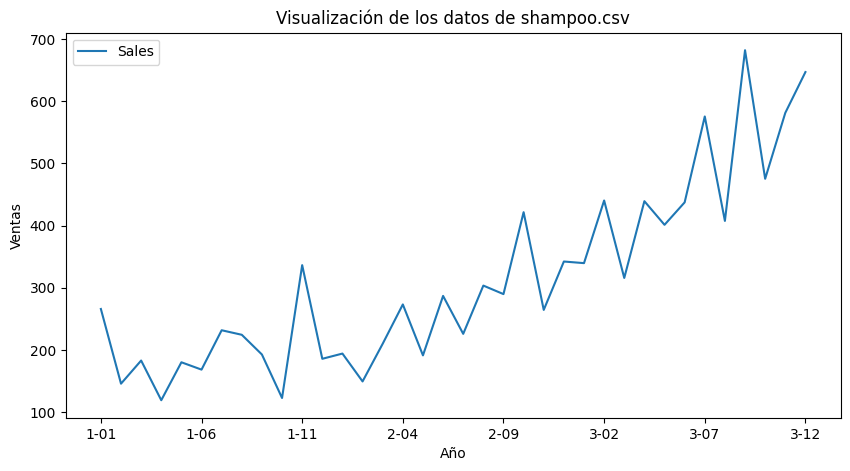

In [63]:
filename = 'shampoo.csv'
datos = pd.read_csv(f'datasets/{filename}',
                    index_col='Month',
                    parse_dates=True)

datos.index.freq = 'MS'

datos.plot(label='Observados', figsize=(10, 5))

plt.legend()
plt.title(f"Visualización de los datos de {filename}")
plt.xlabel("Año")
plt.ylabel("Ventas")
plt.show()

Durante todo el primer a;o no parece existir algun patron de crecimiento, sin embargo luego parece existir un trend donde las ventas aumentan conforme el tiempo. Adicionalmente, cada a;o suele tener picos especialmente en los ultimos meses del a;o (por ejemplo 1-11, 2-10 y 3-12) lo cual nos indica que existe un factor estacional. En cuanto al dataset en si, podemos ver que la informacion esta dividida en meses y realmente no hay una cantidad grande de datos. Podemos predecir lo siguiente basados en la grafica:

- Los modelos sin un factor estacional se quedaran por debajo de los picos, a pesar de captar el trend de crecimiento.
- Los modelos que pongan un mayor enfasis a los datos mas recientes para predecir trends tendran un mejor rendimiento, ya que el trend se empieza a mostrar en fechas mas recientes.
- Los modelos mas efectivos seran los que incluyen factor estacional y trends, como Holt-Winters, SARIMA o Prophet.
- Al tener una cantidad de datos reducidos, el modelo de Prophet tendra un rendimiento menor al esperado.

Para realizar predicciones con el modelo, decidimos utilizar 7 puntos de prueba de los 29 disponibles.

In [64]:
train_size = 29
train = datos.iloc[:train_size]
test = datos.iloc[train_size:]

### 2. Promedios Móviles

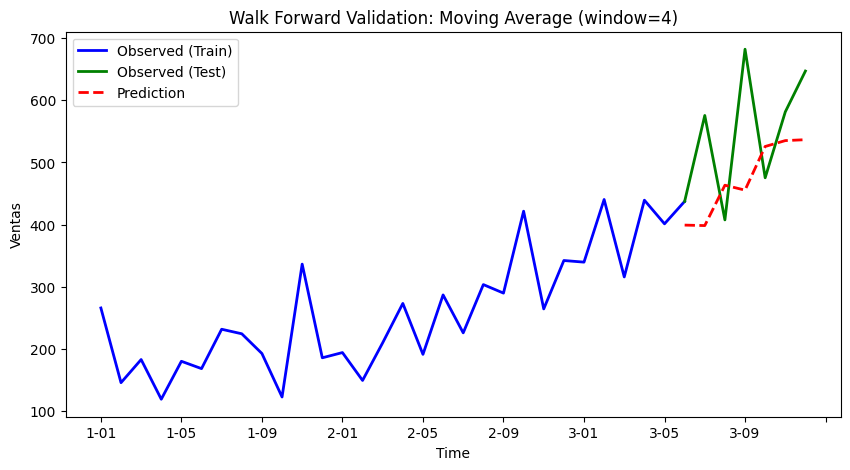

RMSE: 121.93


np.float64(121.93388284523003)

In [65]:
window = 4
history = list(train['Sales'])
preds = []

for t in range(len(test)):
    if len(history) >= window:
        pred = np.mean(history[-window:])
    else:
        pred = np.mean(history)
    preds.append(pred)
    history.append(test['Sales'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Sales',
    title="Walk Forward Validation: Moving Average (window=4)",
    ylabel="Ventas"
)

El modelo de Moving Average tuvo un RMSE de 121.93, visualizando la grafica nos damos cuenta que nuestra prediccion fue correcta. Al no incluir un factor estacional, el modelo es incapaz de predecir los altos picos que se suelen dar en algunos de los ultimos meses del a;o a pesar de captar correctamente el trend. Podemos intentar utilizar un Gridsearch para variar los parametros y encontrar una mejor solucion al problema.

Window: 2, RMSE: 113.15
Window: 3, RMSE: 111.51
Window: 4, RMSE: 121.93
Window: 5, RMSE: 119.48
Window: 6, RMSE: 132.06
Window: 7, RMSE: 137.13
Window: 8, RMSE: 146.07
Window: 9, RMSE: 151.57
Window: 10, RMSE: 159.67
Window: 11, RMSE: 164.96
Window: 12, RMSE: 173.24

Best window: 3 with RMSE: 111.51


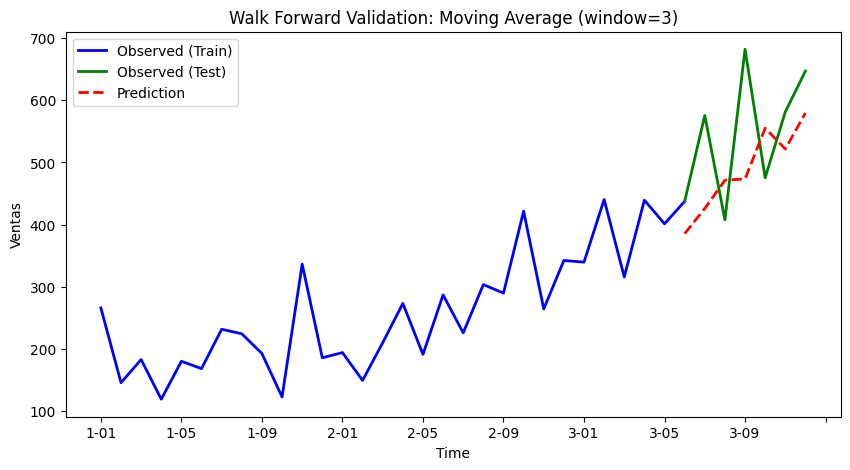

RMSE: 111.51


np.float64(111.5106230258761)

In [66]:
best_rmse = float('inf')
best_window = None
best_preds = None

for window in range(2, 13):
    history = list(train['Sales'])
    preds = []
    for t in range(len(test)):
        if len(history) >= window:
            pred = np.mean(history[-window:])
        else:
            pred = np.mean(history)
        preds.append(pred)
        history.append(test['Sales'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
    print(f"Window: {window}, RMSE: {rmse:.2f}")
    if rmse < best_rmse:
        best_rmse = rmse
        best_window = window
        best_preds = preds

print(f"\nBest window: {best_window} with RMSE: {best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"Walk Forward Validation: Moving Average (window={best_window})",
    ylabel="Ventas"
)

Este modelo tuvo un RMSE de 111.51, lo cual es considerablemente mejor que el anterior. Esto tambien se evidencia por medio de la grafica, donde parece que una ventana mas peque;a permite al modelo enfocarse mas en el ultimo pico de ventas. Esto lleva a valores mas cercanos a los reales, sin embargo, el modelo sigue estando limitado por la falta de componente estacional.

### 3. Alisamiento Exponencial

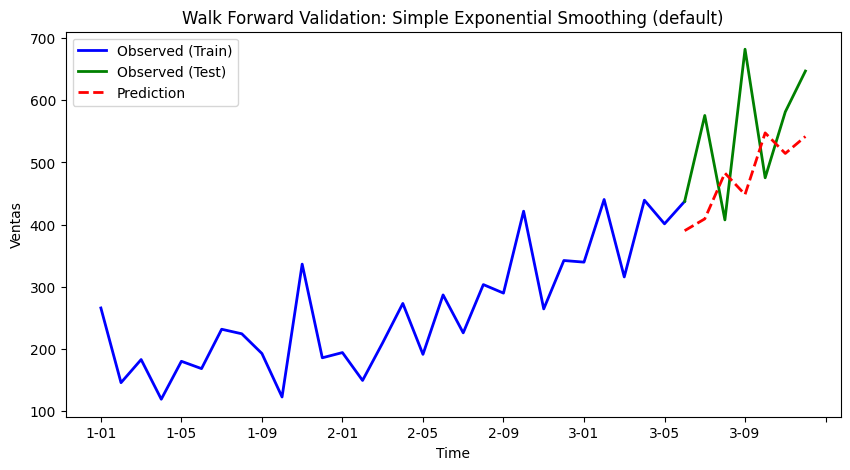

RMSE: 125.84


np.float64(125.84098732784979)

In [67]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

history = list(train['Sales'])
preds = []

for t in range(len(test)):
    model = SimpleExpSmoothing(history).fit(optimized=True)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Sales'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Sales',
    title="Walk Forward Validation: Simple Exponential Smoothing (default)",
    ylabel="Ventas"
)

Este modelo tuvo un RMSE de 125, dentro de la grafica podemos ver que fue incapaz de predecir los cambios estacionales y tampoco fue capaz de ajustarse al ultimo pico de ventas. Ya que SES utiliza smoothing, en este caso es menos efectivo que Moving Averages. Podemos utilizar Gridsearch para variar los parametros y explorar si el mismo modelo con diferentes parametros es capaz de captar el ultimo pico de una manera mas precisa.

Best alpha: 0.43 with RMSE: 123.99


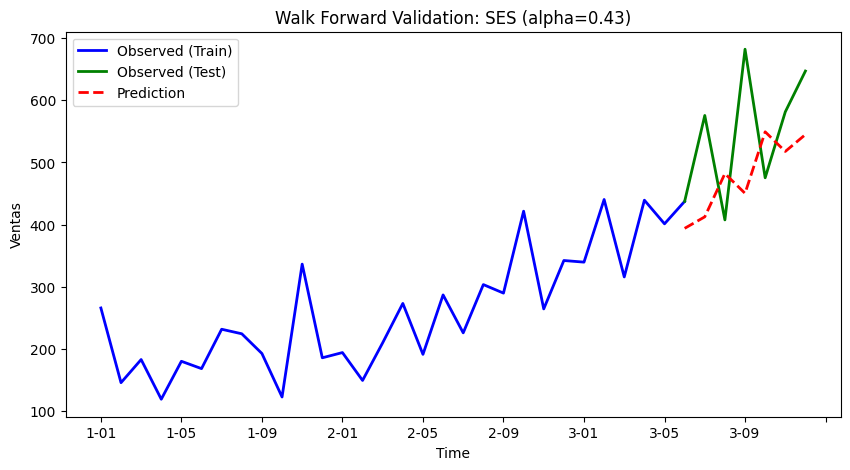

RMSE: 123.99


np.float64(123.98648446926198)

In [68]:
import numpy as np

alphas = np.linspace(0.01, 1.0, 20)
best_rmse = float('inf')
best_alpha = None
best_preds = None

for alpha in alphas:
    history = list(train['Sales'])
    preds = []
    for t in range(len(test)):
        model = SimpleExpSmoothing(history).fit(smoothing_level=alpha, optimized=False)
        pred = model.forecast(1)[0]
        preds.append(pred)
        history.append(test['Sales'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha
        best_preds = preds

print(f"Best alpha: {best_alpha:.2f} with RMSE: {best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"Walk Forward Validation: SES (alpha={best_alpha:.2f})",
    ylabel="Ventas"
)

Luego de variar los parametros, los resultados son bastante similares. Podemos afirmar que no es ideal utilizar un SES para resolver este problema, debido a su falta de factor estacional y capacidad de 'reaccionar' rapidamente a cambios mas abruptos.

### 4. Holt winters

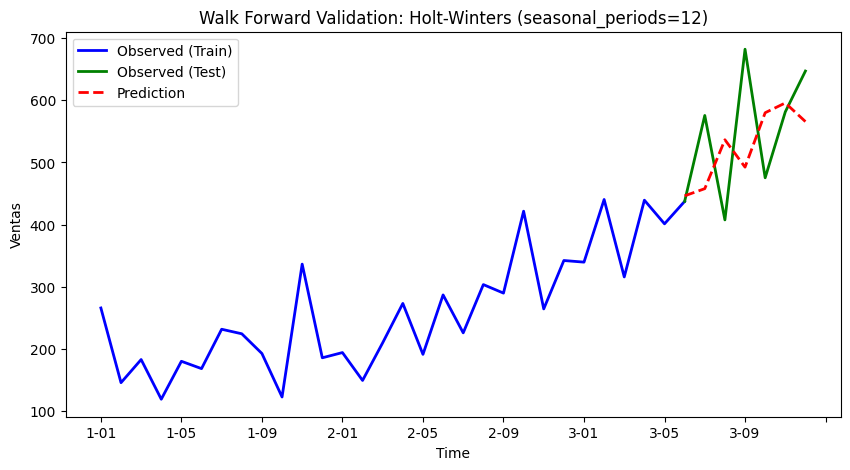

RMSE: 109.69


np.float64(109.68535930057814)

In [69]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

seasonal_periods = 12

history = list(train['Sales'])
history_index = list(train.index)
preds = []

for t in range(len(test)):
    model = ExponentialSmoothing(
        history,
        trend='add',
        seasonal='add',
        seasonal_periods=seasonal_periods
    ).fit(optimized=True)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Sales'].iloc[t])
    history_index.append(test.index[t])

plot_walk_forward(
    train, test, preds, col='Sales',
    title=f"Walk Forward Validation: Holt-Winters (seasonal_periods={seasonal_periods})",
    ylabel="Ventas"
)

Con un RMSE de 109.69, el modelo Holt-Winters es el mas prometedor hasta el momento. Este es el primer modelo que probamos en este dataset que incorpora factor estacional, lo cual se puede apreciar claramente dentro de la grafica. Al incorporar el factor estacional, se puede capturar el trend con tecnicas de smoothing (sin tener que 'reaccionar' rapidamente al ultimo pico como en Moving Averages) y aun asi tener predicciones precisas. Podemos utilizar un Gridsearch para buscar una solucion mas optima al problema.

trend=add, seasonal=add, seasonal_periods=4, RMSE=125.73
trend=add, seasonal=add, seasonal_periods=6, RMSE=107.30
trend=add, seasonal=add, seasonal_periods=12, RMSE=109.69
trend=add, seasonal=None, seasonal_periods=4, RMSE=101.61
trend=add, seasonal=None, seasonal_periods=6, RMSE=101.61
trend=add, seasonal=None, seasonal_periods=12, RMSE=101.61
trend=None, seasonal=add, seasonal_periods=4, RMSE=145.45
trend=None, seasonal=add, seasonal_periods=6, RMSE=134.71
trend=None, seasonal=add, seasonal_periods=12, RMSE=136.27

Best parameters:
trend=add, seasonal=None, seasonal_periods=4, RMSE=101.61


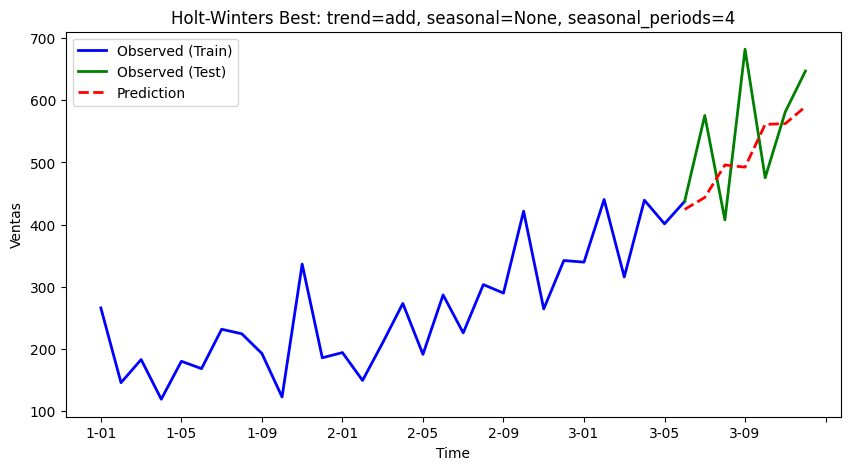

RMSE: 101.61


np.float64(101.61194599324081)

In [70]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

trend_options = ['add', None]
seasonal_options = ['add', None]
seasonal_periods_options = [4, 6, 12]

best_rmse = float('inf')
best_params = None
best_preds = None

for trend in trend_options:
    for seasonal in seasonal_options:
        if trend is None and seasonal is None:
            continue
        for seasonal_periods in seasonal_periods_options:
            history = list(train['Sales'])
            preds = []
            try:
                for t in range(len(test)):
                    model = ExponentialSmoothing(
                        history,
                        trend=trend,
                        seasonal=seasonal,
                        seasonal_periods=seasonal_periods
                    ).fit(optimized=True)
                    pred = model.forecast(1)[0]
                    preds.append(pred)
                    history.append(test['Sales'].iloc[t])
                rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
                print(f"trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods}, RMSE={rmse:.2f}")
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (trend, seasonal, seasonal_periods)
                    best_preds = preds
            except Exception as e:
                print(f"FAILED: trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods} ({e})")

print("\nBest parameters:")
print(f"trend={best_params[0]}, seasonal={best_params[1]}, seasonal_periods={best_params[2]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"Holt-Winters Best: trend={best_params[0]}, seasonal={best_params[1]}, seasonal_periods={best_params[2]}",
    ylabel="Ventas"
)

Luego de realizar un gridsearch, obtenemos el valor mas bajo de RMSE hasta el momento con 101.61. Podemos darnos cuenta tambien dentro de la grafica que predice mejor el incremento el ventas al final de la grafica. Tomando en cuenta el comportamiento erratico al final de nuestros datos, podemos concluir que este modelo fue bastante exitoso prediciendo ventas.

### 5. SARIMA

First test index: 3-06
First prediction index: 3-06
First test value: 437.4
First prediction value: 463.7983884895966


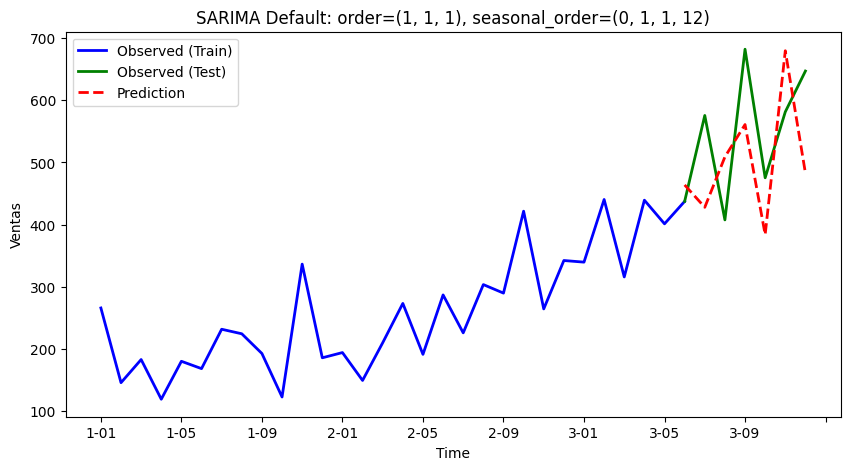

RMSE: 114.88


np.float64(114.87521713673407)

In [71]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

history = list(train['Sales'])
preds = []

order = (1, 1, 1)
seasonal_order = (0, 1, 1, 12)

for t in range(len(test)):
    model = SARIMAX(
        history,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Sales'].iloc[t])

print("First test index:", test.index[0])
print("First prediction index:", test.index[0])  # preds_series uses test.index
print("First test value:", test['Sales'].iloc[0])
print("First prediction value:", preds[0])

plot_walk_forward(
    train, test, preds, col='Sales',
    title=f"SARIMA Default: order={order}, seasonal_order={seasonal_order}",
    ylabel="Ventas"
)

Tomando el cuenta el RMSE, el modelo no es tan prometedor. Sin embargo, viendo la grafica nos podemos dar cuenta que es el unico hasta el momento que predice valores bastante cercanos para los meses de ventas pico. Podemos realizar un Gridsearch para encontrar una mejor solucion.

................................................................
Best parameters:
order=(1, 0, 1), seasonal_order=(1, 0, 1, 12), RMSE=88.19


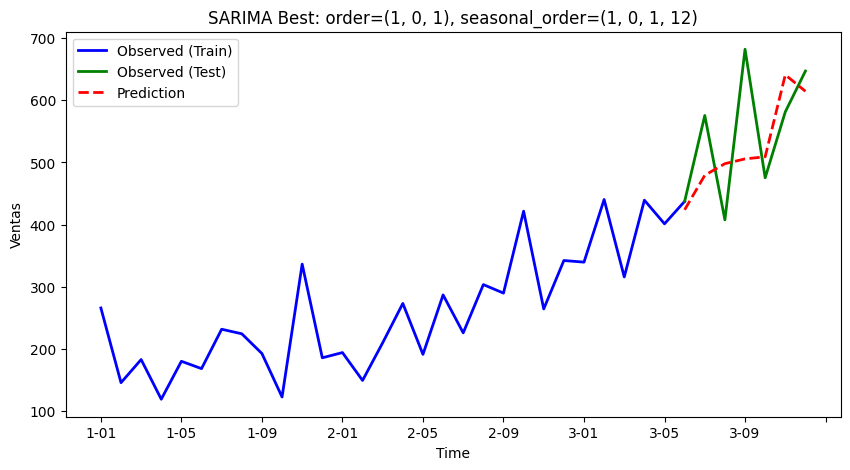

RMSE: 88.19


np.float64(88.18507296980404)

In [72]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import numpy as np
import warnings
warnings.filterwarnings("ignore")

p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = [12]

param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

best_rmse = float('inf')
best_params = None
best_preds = None

for idx, (p_, d_, q_, P_, D_, Q_, s_) in enumerate(param_combinations):
    history = list(train['Sales'])
    preds = []
    try:
        for t in range(len(test)):
            model = SARIMAX(
                history,
                order=(p_, d_, q_),
                seasonal_order=(P_, D_, Q_, s_),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            pred = model.forecast(1)[0]
            preds.append(pred)
            history.append(test['Sales'].iloc[t])
        rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = ((p_, d_, q_), (P_, D_, Q_, s_))
            best_preds = preds
        print('.', end='', flush=True)
    except Exception:
        print('x', end='', flush=True)

print("\nBest parameters:")
print(f"order={best_params[0]}, seasonal_order={best_params[1]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"SARIMA Best: order={best_params[0]}, seasonal_order={best_params[1]}",
    ylabel="Ventas"
)

Luego del Gridsearch, tuvimos como resultado un RMSE de 88.19, el mas bajo hasta el momento. Esto nos indica que este modelo es capaz de captar trends de crecimiento, factores estacionales al igual que otros indicadores para realizar predicciones a futuro. Observando la grafica, el modelo no fue capaz de predecir el comportamiento erratico dentro de los primeros maximos y minimos. Sin embargo, si fue capaz de realizar predicciones bastante precisas entre estos picos. Por ultimo, fue capaz de encontrar el ultimo trend de crecimiento, algo que no hemos visto por parte de los demas modelos.

### 6. Prophet

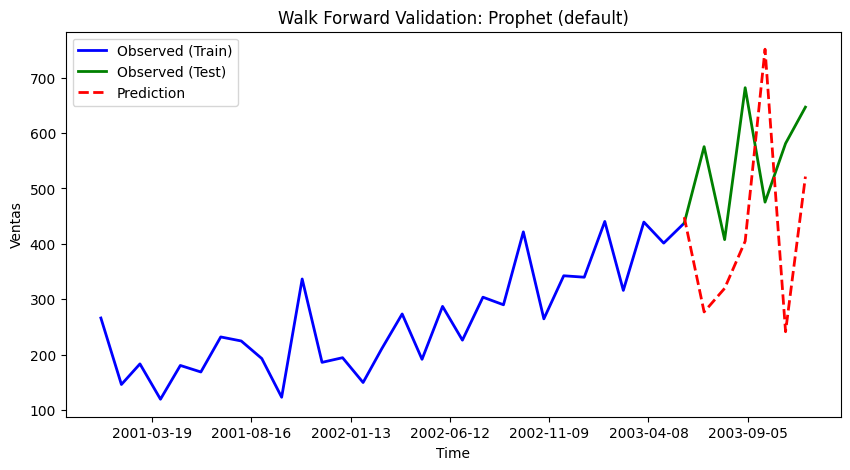

RMSE: 233.47


np.float64(233.46545015561264)

In [73]:
import pandas as pd
from prophet import Prophet

if not pd.api.types.is_datetime64_any_dtype(train.index):
    train = train.copy()
    test = test.copy()
    train['Month'] = pd.date_range(start='2001-01', periods=len(train), freq='MS')
    test['Month'] = pd.date_range(start=train['Month'].iloc[-1] + pd.offsets.MonthBegin(1), periods=len(test), freq='MS')
    train.set_index('Month', inplace=True)
    test.set_index('Month', inplace=True)

train_prophet = train.reset_index().rename(columns={train.index.name or 'index': 'ds', 'Sales': 'y'})
test_prophet = test.reset_index().rename(columns={test.index.name or 'index': 'ds', 'Sales': 'y'})

train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])

history = train_prophet.copy()
preds = []

for t in range(len(test)):
    m = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
    m.fit(history)
    future = pd.DataFrame({'ds': [test_prophet['ds'].iloc[t]]})
    forecast = m.predict(future)
    pred = forecast['yhat'].values[0]
    preds.append(pred)
    history = pd.concat([history, test_prophet.iloc[[t]]], ignore_index=True)

plot_walk_forward(
    train, test, preds, col='Sales',
    title="Walk Forward Validation: Prophet (default)",
    ylabel="Ventas"
)

En este caso, Prophet tuvo un rendimiento sumamente pobre. Las predicciones fueron bastante malas y no fue capaz de ajustarse correctamente. Esto nos puede decir que al tener un conjunto de datos con poca cantidad, se presenta un caso de over-fitting donde el modelo es demasiado flexible y se sobreajusta a los datos.


Best params: mode=additive, changepoint_prior_scale=0.1, RMSE=214.66


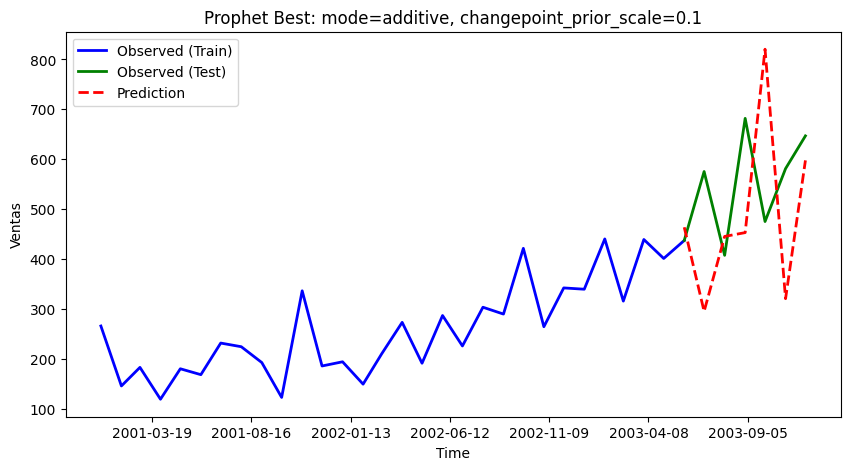

RMSE: 214.66


np.float64(214.6608062514054)

In [74]:
from prophet import Prophet
import numpy as np

seasonality_modes = ['additive', 'multiplicative']
changepoint_scales = [0.01, 0.1, 0.5]

best_rmse = float('inf')
best_params = None
best_preds = None

for mode in seasonality_modes:
    for cps in changepoint_scales:
        history = train_prophet.copy()
        preds = []
        try:
            for t in range(len(test)):
                m = Prophet(
                    yearly_seasonality=True,
                    daily_seasonality=False,
                    weekly_seasonality=False,
                    seasonality_mode=mode,
                    changepoint_prior_scale=cps
                )
                m.fit(history)
                future = pd.DataFrame({'ds': [test_prophet['ds'].iloc[t]]})
                forecast = m.predict(future)
                pred = forecast['yhat'].values[0]
                preds.append(pred)
                history = pd.concat([history, test_prophet.iloc[[t]]], ignore_index=True)
            rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (mode, cps)
                best_preds = preds
        except Exception as e:
            print(f"FAILED: mode={mode}, changepoint_prior_scale={cps} ({e})")

print(f"\nBest params: mode={best_params[0]}, changepoint_prior_scale={best_params[1]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"Prophet Best: mode={best_params[0]}, changepoint_prior_scale={best_params[1]}",
    ylabel="Ventas"
)

Luego de realizar un Gridsearch, podemos concluir que Prophet no es la herramienta adecuada para resolver este problema. Puede que para otros sets de datos dentro de este reporte sea mas apropiado.

### 7. Comparacion y Evaluacion

En el caso de 'shampoo.csv', el mejor modelo fue SARIMA luego de realizar un Gridsearch. Los resultados fueron similares a lo que esperabamos, ya que los modelos sin factor estacional se quedan por detras al unicamente captar trend con RMSE's de 111 y 124 respectivamente. Luego, para Holt-Winters y ARIMA tuvimos RMSE's de 108 y 81. Esta diferencia la podemos explicar debido a la diferencia entre ambos, donde las relaciones entre puntos de este dataset pueden tener patrones mas complejos como autocorrelacion. En este caso, SARIMA tuvo la capacidad de realizar mejores predicciones. Por ultimo, Prophet tuvo un rendimiento sumamente pobre con un RMSE de 214 debido a la baja cantidad de datos y posible sobreajuste al ser un modelo bastante flexible.

## monthly-mean-temp.csv

### 1. Análisis Exploratorio

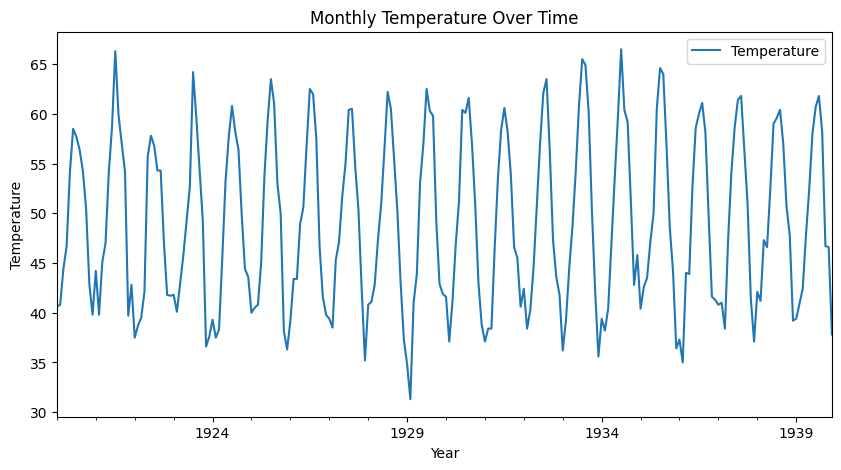

In [75]:
filename = 'monthly-mean-temp.csv'
df = pd.read_csv(f'datasets/{filename}', index_col='Month', parse_dates=True)
df.index.freq = 'MS'

train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

df.plot(figsize=(10, 5), label='Temperature')
plt.title("Monthly Temperature Over Time")
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.legend()
plt.show()

Para este dataset contamos con temperaturas promedio por mes a lo largo de un periodo de tiempo, en este caso podemos observar que realmente no existe un trend hacia arriba. Sin embargo, existen muy altas tendencias estacionales. Esto es de esperarse, ya que la mayoria de variacion en temperatura se da a lo largo de diferentes temporadas de un a;o. Gracias a esto, podemos predecir lo siguiente

- Los modelos sin factor estacional seran completamente incapaces de realizar predicciones
- Los modelos con un factor estacional tendran un rendimiento alto
- SES tendra un mejor rendimiento que Moving Averages al tener un promedio mas alisado a lo largo del tiempo.

### Promedios móviles

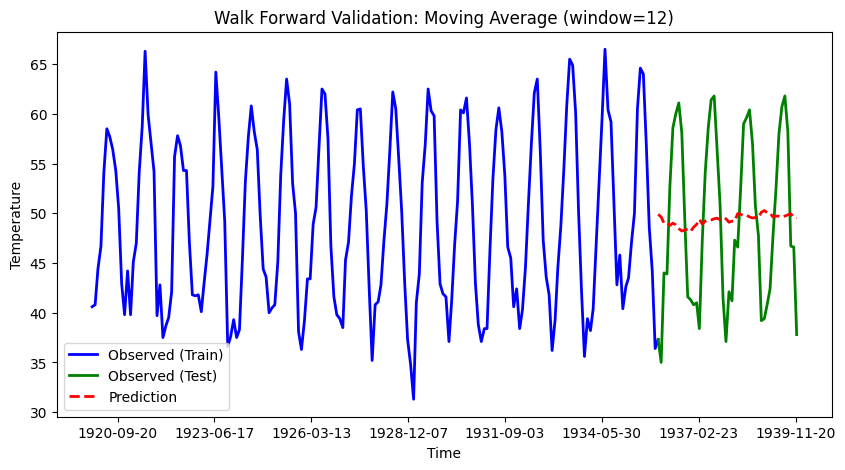

RMSE: 8.38


np.float64(8.384285724286922)

In [76]:
window = 12
history = list(train['Temperature'])
preds = []

for t in range(len(test)):
    if len(history) >= window:
        pred = np.mean(history[-window:])
    else:
        pred = np.mean(history)
    preds.append(pred)
    history.append(test['Temperature'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Temperature',
    title=f"Walk Forward Validation: Moving Average (window={window})",
    ylabel="Temperature"
)

Window: 2, RMSE: 6.60
Window: 3, RMSE: 8.14
Window: 4, RMSE: 9.40
Window: 5, RMSE: 10.34
Window: 6, RMSE: 10.95
Window: 7, RMSE: 11.17
Window: 8, RMSE: 11.02
Window: 9, RMSE: 10.56
Window: 10, RMSE: 9.89
Window: 11, RMSE: 9.11
Window: 12, RMSE: 8.38
Window: 13, RMSE: 7.86
Window: 14, RMSE: 7.66
Window: 15, RMSE: 7.77

Best window: 2 with RMSE: 6.60


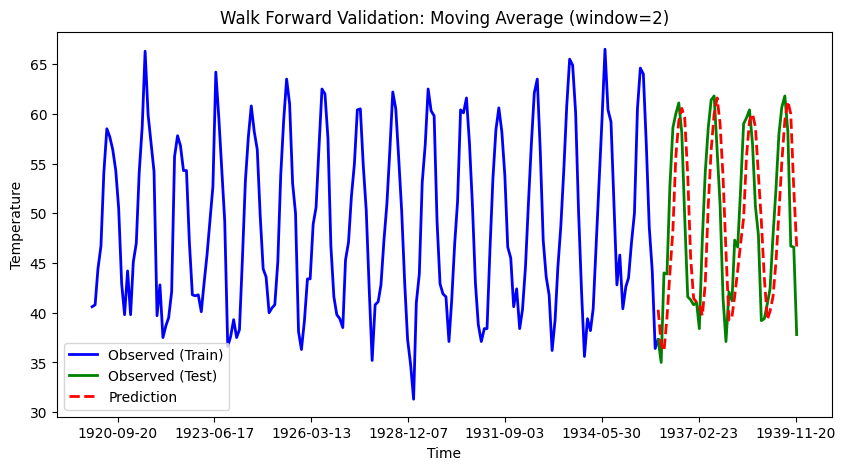

RMSE: 6.60


np.float64(6.595216069242917)

In [77]:
from sklearn.metrics import mean_squared_error
import numpy as np

best_rmse = float('inf')
best_window = None
best_preds = None

for window in range(2, 16):  # Try window sizes from 2 to 12
    history = list(train['Temperature'])
    preds = []
    for t in range(len(test)):
        if len(history) >= window:
            pred = np.mean(history[-window:])
        else:
            pred = np.mean(history)
        preds.append(pred)
        history.append(test['Temperature'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Temperature'], preds))
    print(f"Window: {window}, RMSE: {rmse:.2f}")
    if rmse < best_rmse:
        best_rmse = rmse
        best_window = window
        best_preds = preds

print(f"\nBest window: {best_window} with RMSE: {best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Temperature',
    title=f"Walk Forward Validation: Moving Average (window={best_window})",
    ylabel="Temperature"
)

### Alisamiento exponencial

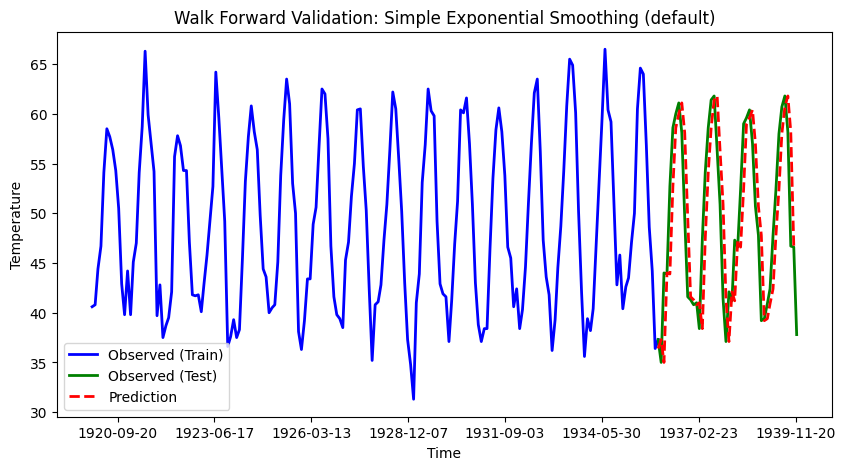

RMSE: 5.14


np.float64(5.143604473515007)

In [78]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

history = list(train['Temperature'])
preds = []

for t in range(len(test)):
    model = SimpleExpSmoothing(history).fit(optimized=True)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Temperature'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Temperature',
    title="Walk Forward Validation: Simple Exponential Smoothing (default)",
    ylabel="Temperature"
)

Best alpha: 1.00 with RMSE: 5.14


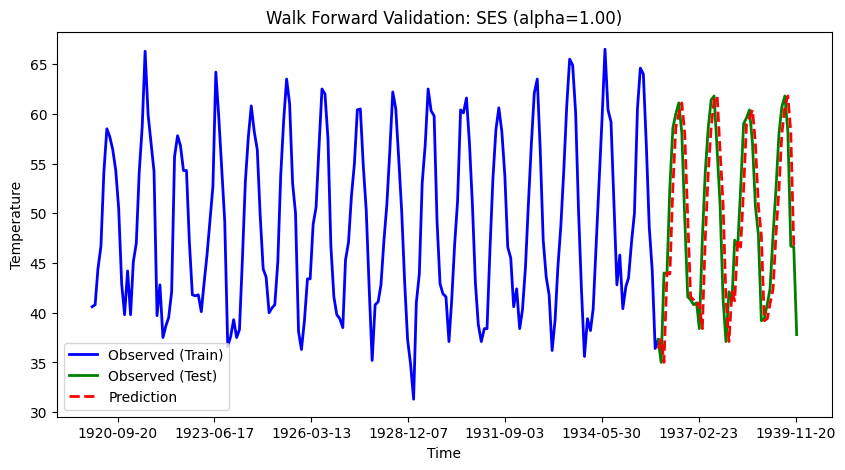

RMSE: 5.14


np.float64(5.143604443060009)

In [79]:
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error

alphas = np.linspace(0.01, 1.0, 20)
best_rmse = float('inf')
best_alpha = None
best_preds = None

for alpha in alphas:
    history = list(train['Temperature'])
    preds = []
    for t in range(len(test)):
        model = SimpleExpSmoothing(history).fit(smoothing_level=alpha, optimized=False)
        pred = model.forecast(1)[0]
        preds.append(pred)
        history.append(test['Temperature'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Temperature'], preds))
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha
        best_preds = preds

print(f"Best alpha: {best_alpha:.2f} with RMSE: {best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Temperature',
    title=f"Walk Forward Validation: SES (alpha={best_alpha:.2f})",
    ylabel="Temperature"
)

### Holt winters

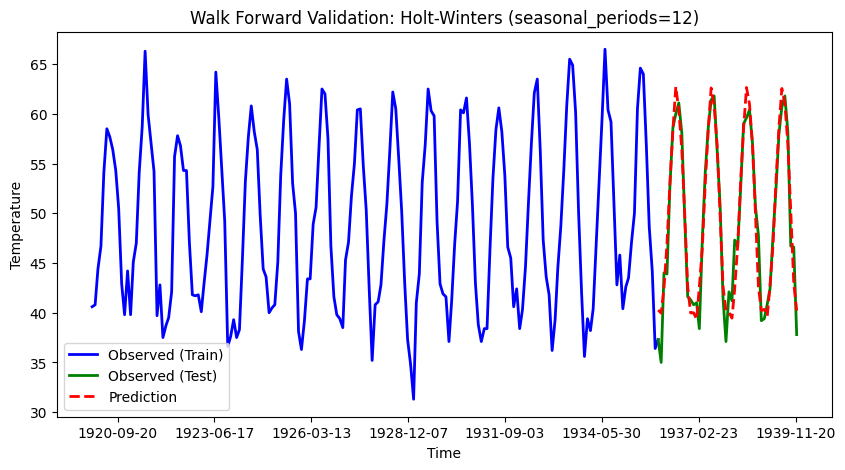

RMSE: 2.08


np.float64(2.084366625436126)

In [80]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

seasonal_periods = 12

history = list(train['Temperature'])
preds = []

for t in range(len(test)):
    model = ExponentialSmoothing(
        history,
        trend='add',
        seasonal='add',
        seasonal_periods=seasonal_periods
    ).fit(optimized=True)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Temperature'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Temperature',
    title=f"Walk Forward Validation: Holt-Winters (seasonal_periods={seasonal_periods})",
    ylabel="Temperature"
)

trend=add, seasonal=add, seasonal_periods=4, RMSE=5.01
trend=add, seasonal=add, seasonal_periods=6, RMSE=5.09
trend=add, seasonal=add, seasonal_periods=12, RMSE=2.08
trend=add, seasonal=None, seasonal_periods=4, RMSE=5.08
trend=add, seasonal=None, seasonal_periods=6, RMSE=5.08
trend=add, seasonal=None, seasonal_periods=12, RMSE=5.08
trend=None, seasonal=add, seasonal_periods=4, RMSE=5.13
trend=None, seasonal=add, seasonal_periods=6, RMSE=5.16
trend=None, seasonal=add, seasonal_periods=12, RMSE=2.12

Best parameters:
trend=add, seasonal=add, seasonal_periods=12, RMSE=2.08


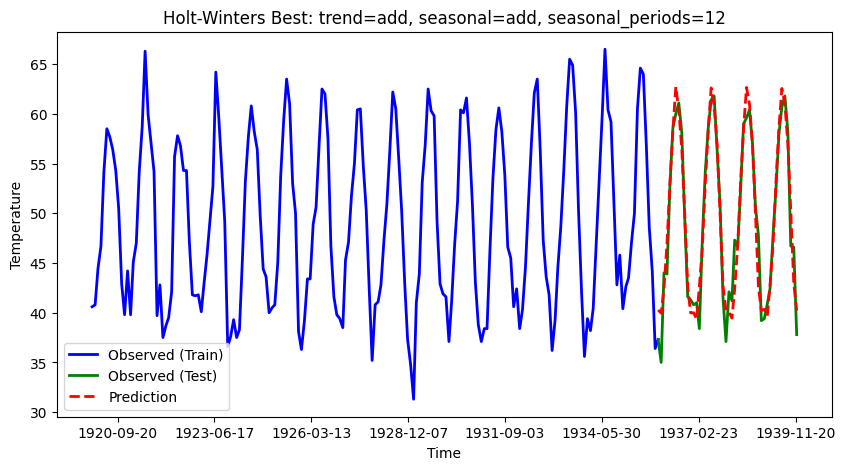

RMSE: 2.08


np.float64(2.084366625436126)

In [81]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

trend_options = ['add', None]
seasonal_options = ['add', None]
seasonal_periods_options = [4, 6, 12]

best_rmse = float('inf')
best_params = None
best_preds = None

for trend in trend_options:
    for seasonal in seasonal_options:
        if trend is None and seasonal is None:
            continue
        for seasonal_periods in seasonal_periods_options:
            history = list(train['Temperature'])
            preds = []
            try:
                for t in range(len(test)):
                    model = ExponentialSmoothing(
                        history,
                        trend=trend,
                        seasonal=seasonal,
                        seasonal_periods=seasonal_periods
                    ).fit(optimized=True)
                    pred = model.forecast(1)[0]
                    preds.append(pred)
                    history.append(test['Temperature'].iloc[t])
                rmse = np.sqrt(mean_squared_error(test['Temperature'], preds))
                print(f"trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods}, RMSE={rmse:.2f}")
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (trend, seasonal, seasonal_periods)
                    best_preds = preds
            except Exception as e:
                print(f"FAILED: trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods} ({e})")

print("\nBest parameters:")
print(f"trend={best_params[0]}, seasonal={best_params[1]}, seasonal_periods={best_params[2]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Temperature',
    title=f"Holt-Winters Best: trend={best_params[0]}, seasonal={best_params[1]}, seasonal_periods={best_params[2]}",
    ylabel="Temperature"
)

### SARIMA

First test index: 1936-01-01 00:00:00
First prediction index: 1936-01-01 00:00:00
First test value: 37.3
First prediction value: 38.83888061695194


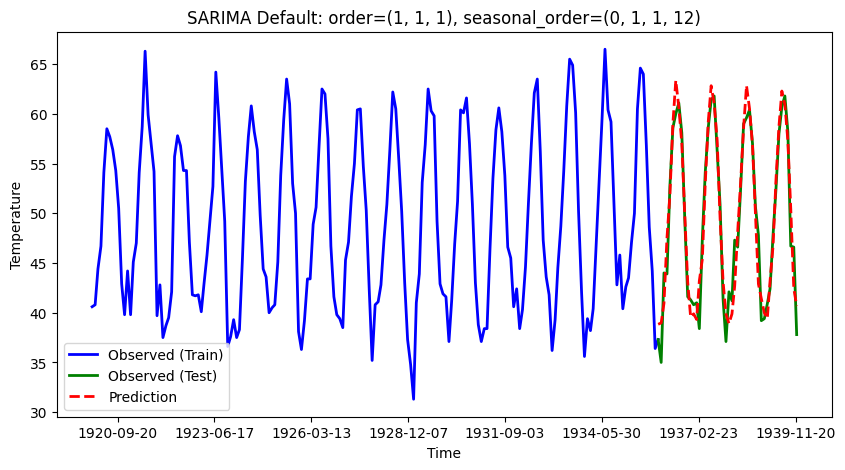

RMSE: 2.21


np.float64(2.2057661340223853)

In [82]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (1, 1, 1)
seasonal_order = (0, 1, 1, 12)

history = list(train['Temperature'])
preds = []

for t in range(len(test)):
    model = SARIMAX(
        history,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Temperature'].iloc[t])

print("First test index:", test.index[0])
print("First prediction index:", test.index[0])  # preds_series uses test.index
print("First test value:", test['Temperature'].iloc[0])
print("First prediction value:", preds[0])

plot_walk_forward(
    train, test, preds, col='Temperature',
    title=f"SARIMA Default: order={order}, seasonal_order={seasonal_order}",
    ylabel="Temperature"
)

................................................................
Best parameters:
order=(0, 0, 0), seasonal_order=(0, 1, 1, 12), RMSE=2.09


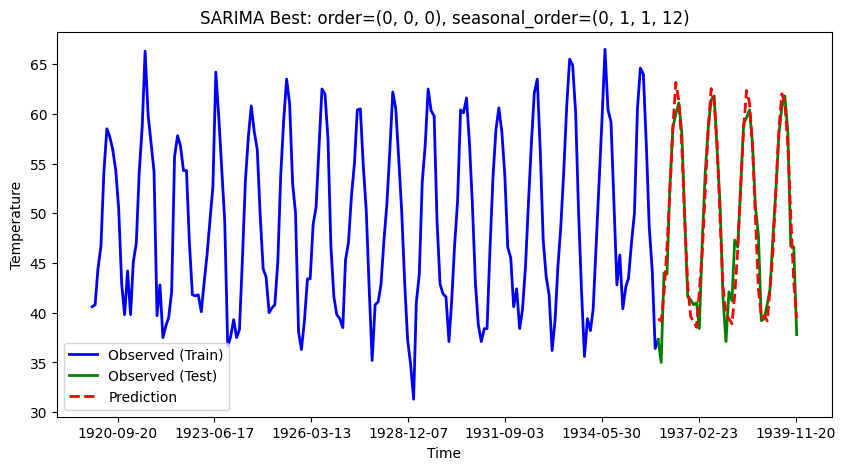

RMSE: 2.09


np.float64(2.085793998147804)

In [83]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import numpy as np
import warnings
warnings.filterwarnings("ignore")

p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = [12]

param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

best_rmse = float('inf')
best_params = None
best_preds = None

for idx, (p_, d_, q_, P_, D_, Q_, s_) in enumerate(param_combinations):
    history = list(train['Temperature'])
    preds = []
    try:
        for t in range(len(test)):
            model = SARIMAX(
                history,
                order=(p_, d_, q_),
                seasonal_order=(P_, D_, Q_, s_),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            pred = model.forecast(1)[0]
            preds.append(pred)
            history.append(test['Temperature'].iloc[t])
        rmse = np.sqrt(mean_squared_error(test['Temperature'], preds))
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = ((p_, d_, q_), (P_, D_, Q_, s_))
            best_preds = preds
        print('.', end='', flush=True)
    except Exception:
        print('x', end='', flush=True)

print("\nBest parameters:")
print(f"order={best_params[0]}, seasonal_order={best_params[1]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Temperature',
    title=f"SARIMA Best: order={best_params[0]}, seasonal_order={best_params[1]}",
    ylabel="Temperature"
)

### Prophet

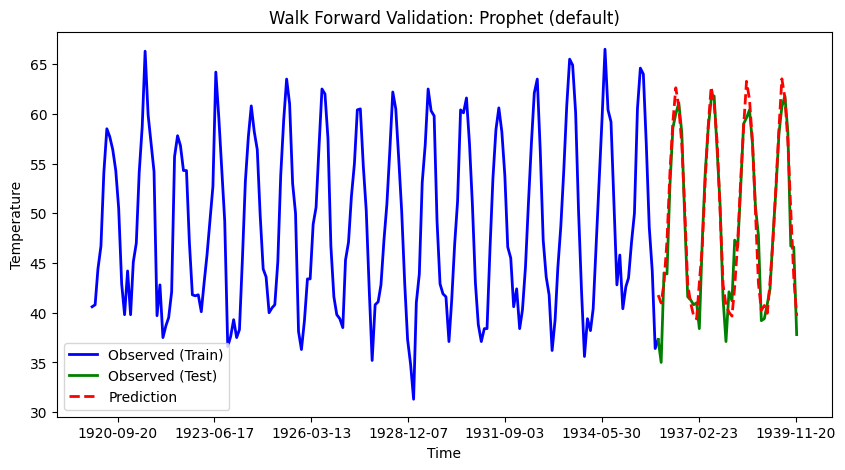

RMSE: 2.20


np.float64(2.2036300761803984)

In [84]:
import pandas as pd
from prophet import Prophet

# Ensure index is datetime and set up for temperature data
if not pd.api.types.is_datetime64_any_dtype(train.index):
    train = train.copy()
    test = test.copy()
    train['Month'] = pd.date_range(start='1920-01', periods=len(train), freq='MS')
    test['Month'] = pd.date_range(start=train['Month'].iloc[-1] + pd.offsets.MonthBegin(1), periods=len(test), freq='MS')
    train.set_index('Month', inplace=True)
    test.set_index('Month', inplace=True)

train_prophet = train.reset_index().rename(columns={train.index.name or 'index': 'ds', 'Temperature': 'y'})
test_prophet = test.reset_index().rename(columns={test.index.name or 'index': 'ds', 'Temperature': 'y'})

train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])

history = train_prophet.copy()
preds = []

for t in range(len(test)):
    m = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
    m.fit(history)
    future = pd.DataFrame({'ds': [test_prophet['ds'].iloc[t]]})
    forecast = m.predict(future)
    pred = forecast['yhat'].values[0]
    preds.append(pred)
    history = pd.concat([history, test_prophet.iloc[[t]]], ignore_index=True)

plot_walk_forward(
    train, test, preds, col='Temperature',
    title="Walk Forward Validation: Prophet (default)",
    ylabel="Temperature"
)

mode=additive, changepoint_prior_scale=0.01, RMSE=2.06
mode=additive, changepoint_prior_scale=0.1, RMSE=2.24
mode=additive, changepoint_prior_scale=0.5, RMSE=2.31
mode=multiplicative, changepoint_prior_scale=0.01, RMSE=2.10
mode=multiplicative, changepoint_prior_scale=0.1, RMSE=2.25
mode=multiplicative, changepoint_prior_scale=0.5, RMSE=2.30

Best params: mode=additive, changepoint_prior_scale=0.01, RMSE=2.06


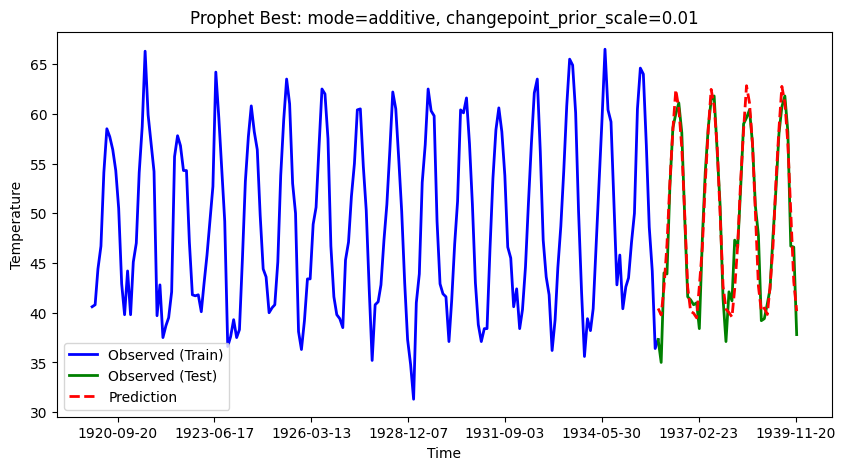

RMSE: 2.06


np.float64(2.063245850160289)

In [85]:
from prophet import Prophet
import numpy as np

seasonality_modes = ['additive', 'multiplicative']
changepoint_scales = [0.01, 0.1, 0.5]

best_rmse = float('inf')
best_params = None
best_preds = None

for mode in seasonality_modes:
    for cps in changepoint_scales:
        history = train_prophet.copy()
        preds = []
        try:
            for t in range(len(test)):
                m = Prophet(
                    yearly_seasonality=True,
                    daily_seasonality=False,
                    weekly_seasonality=False,
                    seasonality_mode=mode,
                    changepoint_prior_scale=cps
                )
                m.fit(history)
                future = pd.DataFrame({'ds': [test_prophet['ds'].iloc[t]]})
                forecast = m.predict(future)
                pred = forecast['yhat'].values[0]
                preds.append(pred)
                history = pd.concat([history, test_prophet.iloc[[t]]], ignore_index=True)
            rmse = np.sqrt(mean_squared_error(test['Temperature'], preds))
            print(f"mode={mode}, changepoint_prior_scale={cps}, RMSE={rmse:.2f}")
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (mode, cps)
                best_preds = preds
        except Exception as e:
            print(f"FAILED: mode={mode}, changepoint_prior_scale={cps} ({e})")

print(f"\nBest params: mode={best_params[0]}, changepoint_prior_scale={best_params[1]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Temperature',
    title=f"Prophet Best: mode={best_params[0]}, changepoint_prior_scale={best_params[1]}",
    ylabel="Temperature"
)

### Comparacion y Evaluacion

## monthly-car-sales.csv

### Análisis exploratorio

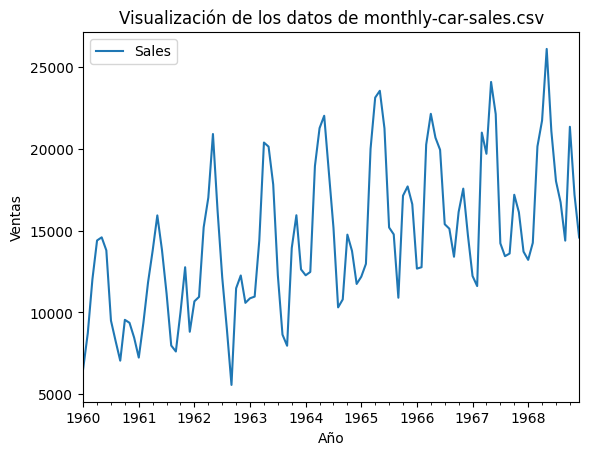

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
filename = 'monthly-car-sales.csv'
df = pd.read_csv(filename, index_col='Month', parse_dates=True)
df.index.freq = 'MS'  # Monthly Start

# Split into train/test (80/20 split)
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

df.plot(figsize=(10, 5), label='Sales')
plt.title("Monthly Car Sales Over Time")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.legend()
plt.show()

### Promedios móviles

In [ ]:
window = 12  # 1 year for monthly data
history = list(train['Sales'])
preds = []
for t in range(len(test)):
    if len(history) >= window:
        pred = np.mean(history[-window:])
    else:
        pred = np.mean(history)
    preds.append(pred)
    history.append(test['Sales'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Sales',
    title=f"Walk Forward Validation: Moving Average (window={window})",
    ylabel="Sales"
)

In [ ]:
from sklearn.metrics import mean_squared_error

best_rmse = float('inf')
best_window = None
best_preds = None

for window in range(2, 13):
    history = list(train['Sales'])
    preds = []
    for t in range(len(test)):
        if len(history) >= window:
            pred = np.mean(history[-window:])
        else:
            pred = np.mean(history)
        preds.append(pred)
        history.append(test['Sales'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
    if rmse < best_rmse:
        best_rmse = rmse
        best_window = window
        best_preds = preds

print(f"Best window: {best_window} with RMSE: {best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"Walk Forward Validation: Moving Average (window={best_window})",
    ylabel="Sales"
)

### Alisamiento exponencial

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

history = list(train['Sales'])
preds = []
for t in range(len(test)):
    model = SimpleExpSmoothing(history).fit(optimized=True)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Sales'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Sales',
    title="Walk Forward Validation: SES (default)",
    ylabel="Sales"
)

In [ ]:
alphas = np.linspace(0.01, 1.0, 20)
best_rmse = float('inf')
best_alpha = None
best_preds = None

for alpha in alphas:
    history = list(train['Sales'])
    preds = []
    for t in range(len(test)):
        model = SimpleExpSmoothing(history).fit(smoothing_level=alpha, optimized=False)
        pred = model.forecast(1)[0]
        preds.append(pred)
        history.append(test['Sales'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha
        best_preds = preds

print(f"Best alpha: {best_alpha:.2f} with RMSE: {best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"Walk Forward Validation: SES (alpha={best_alpha:.2f})",
    ylabel="Sales"
)

### Holt winters

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

seasonal_periods = 12  # yearly seasonality
history = list(train['Sales'])
preds = []
for t in range(len(test)):
    model = ExponentialSmoothing(
        history,
        trend='add',
        seasonal='add',
        seasonal_periods=seasonal_periods
    ).fit(optimized=True)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Sales'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Sales',
    title=f"Walk Forward Validation: Holt-Winters (seasonal_periods={seasonal_periods})",
    ylabel="Sales"
)

In [ ]:
trend_options = ['add', None]
seasonal_options = ['add', None]
seasonal_periods_options = [6, 12]

best_rmse = float('inf')
best_params = None
best_preds = None

for trend in trend_options:
    for seasonal in seasonal_options:
        if trend is None and seasonal is None:
            continue
        for seasonal_periods in seasonal_periods_options:
            history = list(train['Sales'])
            preds = []
            try:
                for t in range(len(test)):
                    model = ExponentialSmoothing(
                        history,
                        trend=trend,
                        seasonal=seasonal,
                        seasonal_periods=seasonal_periods
                    ).fit(optimized=True)
                    pred = model.forecast(1)[0]
                    preds.append(pred)
                    history.append(test['Sales'].iloc[t])
                rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (trend, seasonal, seasonal_periods)
                    best_preds = preds
            except Exception as e:
                print(f"FAILED: trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods} ({e})")

print(f"Best params: trend={best_params[0]}, seasonal={best_params[1]}, seasonal_periods={best_params[2]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"Holt-Winters Best: trend={best_params[0]}, seasonal={best_params[1]}, seasonal_periods={best_params[2]}",
    ylabel="Sales"
)

### SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (1, 1, 1)
seasonal_order = (0, 1, 1, 12)

history = list(train['Sales'])
preds = []
for t in range(len(test)):
    model = SARIMAX(
        history,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Sales'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Sales',
    title=f"SARIMA Default: order={order}, seasonal_order={seasonal_order}",
    ylabel="Sales"
)

In [ ]:
import itertools
import warnings
warnings.filterwarnings("ignore")

p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = [12]

param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

best_rmse = float('inf')
best_params = None
best_preds = None

for idx, (p_, d_, q_, P_, D_, Q_, s_) in enumerate(param_combinations):
    history = list(train['Sales'])
    preds = []
    try:
        for t in range(len(test)):
            model = SARIMAX(
                history,
                order=(p_, d_, q_),
                seasonal_order=(P_, D_, Q_, s_),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            pred = model.forecast(1)[0]
            preds.append(pred)
            history.append(test['Sales'].iloc[t])
        rmse = np.sqrt(mean_squared_error(test['Sales'], preds))
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = ((p_, d_, q_), (P_, D_, Q_, s_))
            best_preds = preds
        print('.', end='', flush=True)
    except Exception:
        print('x', end='', flush=True)

print(f"\nBest params: order={best_params[0]}, seasonal_order={best_params[1]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Sales',
    title=f"SARIMA Best: order={best_params[0]}, seasonal_order={best_params[1]}",
    ylabel="Sales"
)

### Prophet

In [ ]:
from prophet import Prophet

# Ensure index is datetime
if not pd.api.types.is_datetime64_any_dtype(train.index):
    train = train.copy()
    test = test.copy()
    train['Month'] = pd.date_range(start='1960-01', periods=len(train), freq='MS')
    test['Month'] = pd.date_range(start=train['Month'].iloc[-1] + pd.offsets.MonthBegin(1), periods=len(test), freq='MS')
    train.set_index('Month', inplace=True)
    test.set_index('Month', inplace=True)

train_prophet = train.reset_index().rename(columns={train.index.name or 'index': 'ds', 'Sales': 'y'})
test_prophet = test.reset_index().rename(columns={test.index.name or 'index': 'ds', 'Sales': 'y'})
train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])

history = train_prophet.copy()
preds = []
for t in range(len(test)):
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(history)
    future = pd.DataFrame({'ds': [test_prophet['ds'].iloc[t]]})
    forecast = m.predict(future)
    pred = forecast['yhat'].values[0]
    preds.append(pred)
    history = pd.concat([history, test_prophet.iloc[[t]]], ignore_index=True)

plot_walk_forward(
    train, test, preds, col='Sales',
    title="Walk Forward Validation: Prophet (default)",
    ylabel="Sales"
)

In [ ]:
from prophet import Prophet

# Ensure index is datetime
if not pd.api.types.is_datetime64_any_dtype(train.index):
    train = train.copy()
    test = test.copy()
    train['Month'] = pd.date_range(start='1960-01', periods=len(train), freq='MS')
    test['Month'] = pd.date_range(start=train['Month'].iloc[-1] + pd.offsets.MonthBegin(1), periods=len(test), freq='MS')
    train.set_index('Month', inplace=True)
    test.set_index('Month', inplace=True)

train_prophet = train.reset_index().rename(columns={train.index.name or 'index': 'ds', 'Sales': 'y'})
test_prophet = test.reset_index().rename(columns={test.index.name or 'index': 'ds', 'Sales': 'y'})
train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])

history = train_prophet.copy()
preds = []
for t in range(len(test)):
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(history)
    future = pd.DataFrame({'ds': [test_prophet['ds'].iloc[t]]})
    forecast = m.predict(future)
    pred = forecast['yhat'].values[0]
    preds.append(pred)
    history = pd.concat([history, test_prophet.iloc[[t]]], ignore_index=True)

plot_walk_forward(
    train, test, preds, col='Sales',
    title="Walk Forward Validation: Prophet (default)",
    ylabel="Sales"
)

### Comparacion y Evaluacion

## daily-total-female-births.csv

### Análisis exploratorio

           Births
count  365.000000
mean    41.980822
std      7.348257
min     23.000000
25%     37.000000
50%     42.000000
75%     46.000000
max     73.000000


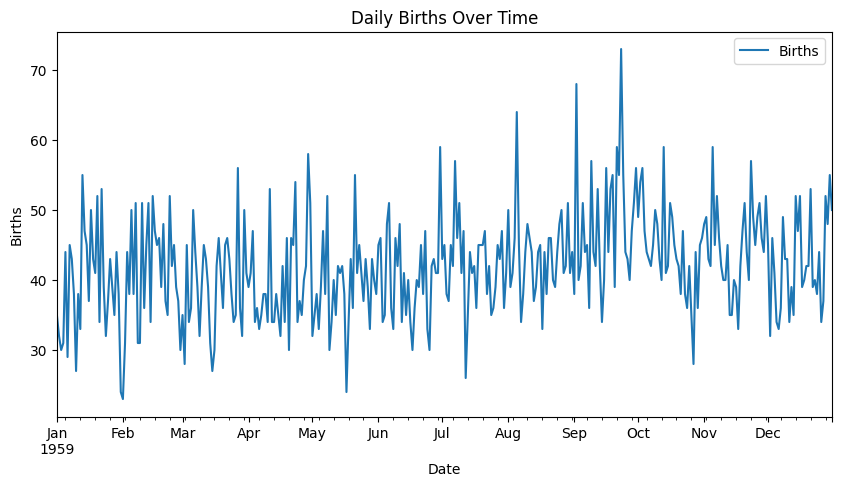

In [90]:
filename = 'daily-total-female-births.csv'
df = pd.read_csv(f'datasets/{filename}', index_col='Date', parse_dates=True)
df.index.freq = 'D'

# Split into train/test (80/20 split)
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

print(df.describe())

df.plot(figsize=(10, 5), label='Births')
plt.title("Daily Births Over Time")
plt.xlabel("Date")
plt.ylabel("Births")
plt.legend()
plt.show()

### Promedios móviles

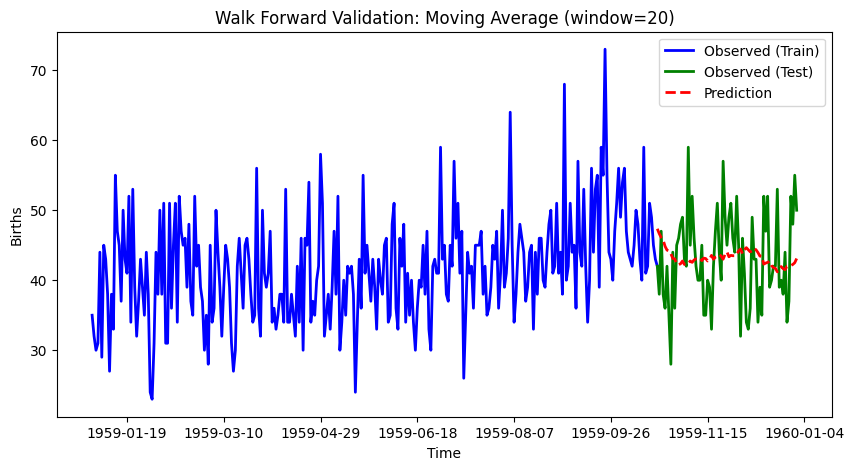

RMSE: 6.81


np.float64(6.809127134131593)

In [91]:
window = 20
history = list(train['Births'])
preds = []
for t in range(len(test)):
    if len(history) >= window:
        pred = np.mean(history[-window:])
    else:
        pred = np.mean(history)
    preds.append(pred)
    history.append(test['Births'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Births',
    title=f"Walk Forward Validation: Moving Average (window={window})",
    ylabel="Births"
)

Best window: 5 with RMSE: 6.71


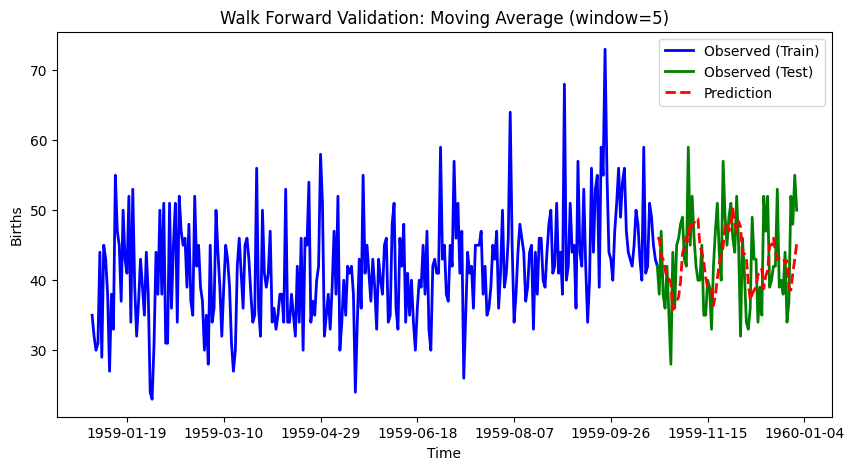

RMSE: 6.71


np.float64(6.710000714533575)

In [92]:
from sklearn.metrics import mean_squared_error
import numpy as np

best_rmse = float('inf')
best_window = None
best_preds = None

for window in range(5, 50, 5):
    history = list(train['Births'])
    preds = []
    for t in range(len(test)):
        if len(history) >= window:
            pred = np.mean(history[-window:])
        else:
            pred = np.mean(history)
        preds.append(pred)
        history.append(test['Births'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Births'], preds))
    if rmse < best_rmse:
        best_rmse = rmse
        best_window = window
        best_preds = preds

print(f"Best window: {best_window} with RMSE: {best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Births',
    title=f"Walk Forward Validation: Moving Average (window={best_window})",
    ylabel="Births"
)

### Alisamiento exponencial

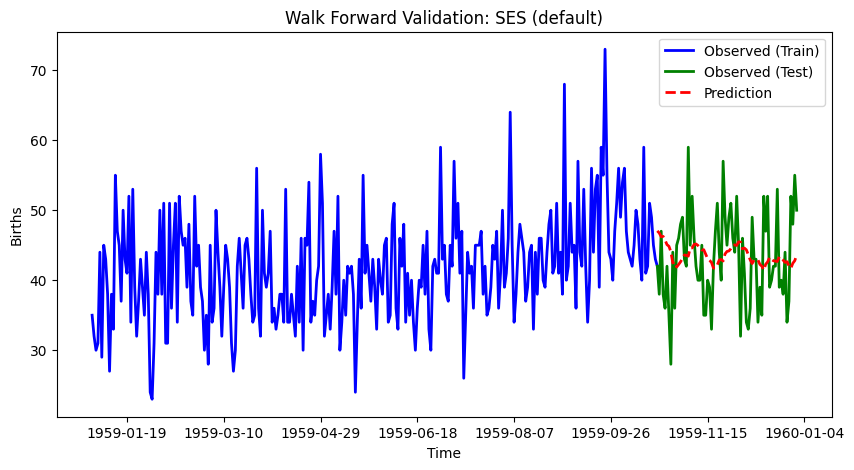

RMSE: 6.77


np.float64(6.7728993475604735)

In [93]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

history = list(train['Births'])
preds = []
for t in range(len(test)):
    model = SimpleExpSmoothing(history).fit(optimized=True)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Births'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Births',
    title="Walk Forward Validation: SES (default)",
    ylabel="Births"
)

Best alpha: 0.01 with RMSE: 6.46


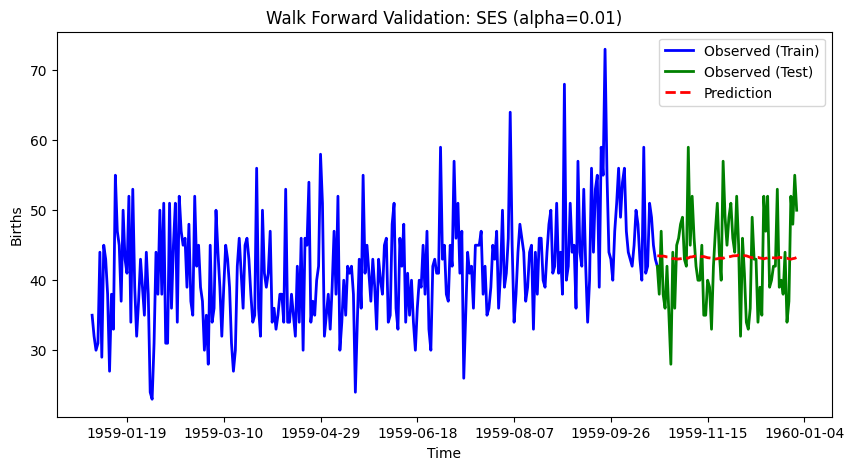

RMSE: 6.46


np.float64(6.463403022876727)

In [94]:
alphas = np.linspace(0.01, 1.0, 20)
best_rmse = float('inf')
best_alpha = None
best_preds = None

for alpha in alphas:
    history = list(train['Births'])
    preds = []
    for t in range(len(test)):
        model = SimpleExpSmoothing(history).fit(smoothing_level=alpha, optimized=False)
        pred = model.forecast(1)[0]
        preds.append(pred)
        history.append(test['Births'].iloc[t])
    rmse = np.sqrt(mean_squared_error(test['Births'], preds))
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha
        best_preds = preds

print(f"Best alpha: {best_alpha:.2f} with RMSE: {best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Births',
    title=f"Walk Forward Validation: SES (alpha={best_alpha:.2f})",
    ylabel="Births"
)

### Holt winter

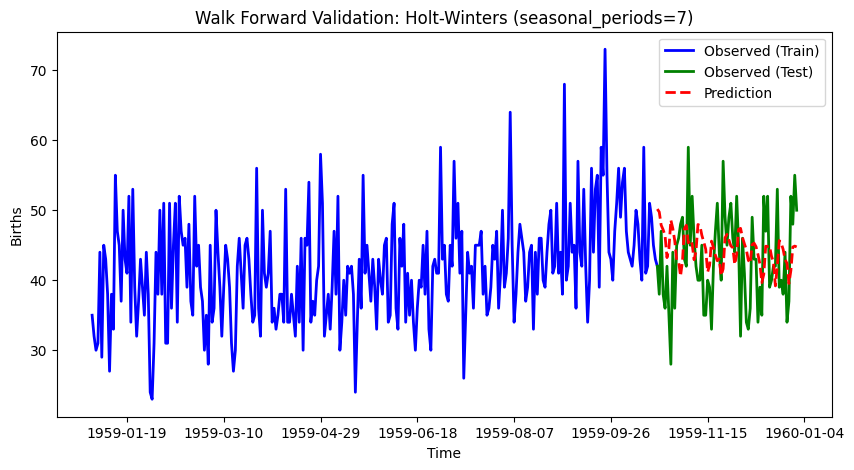

RMSE: 7.25


np.float64(7.253876914013144)

In [95]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

seasonal_periods = 7  # Weekly seasonality for daily data
history = list(train['Births'])
preds = []
for t in range(len(test)):
    model = ExponentialSmoothing(
        history,
        trend='add',
        seasonal='add',
        seasonal_periods=seasonal_periods
    ).fit(optimized=True)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Births'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Births',
    title=f"Walk Forward Validation: Holt-Winters (seasonal_periods={seasonal_periods})",
    ylabel="Births"
)

Best params: trend=add, seasonal=None, seasonal_periods=7, RMSE=6.94


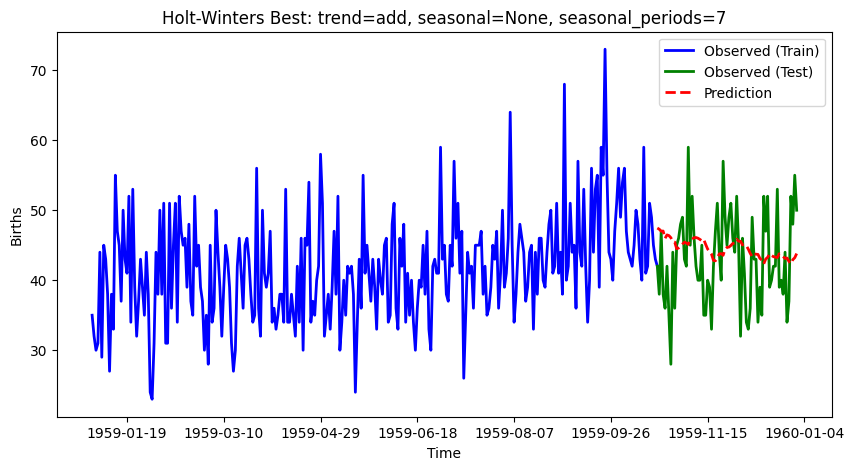

RMSE: 6.94


np.float64(6.9392319406660805)

In [96]:
trend_options = ['add', None]
seasonal_options = ['add', None]
seasonal_periods_options = [7, 14]

best_rmse = float('inf')
best_params = None
best_preds = None

for trend in trend_options:
    for seasonal in seasonal_options:
        if trend is None and seasonal is None:
            continue
        for seasonal_periods in seasonal_periods_options:
            history = list(train['Births'])
            preds = []
            try:
                for t in range(len(test)):
                    model = ExponentialSmoothing(
                        history,
                        trend=trend,
                        seasonal=seasonal,
                        seasonal_periods=seasonal_periods
                    ).fit(optimized=True)
                    pred = model.forecast(1)[0]
                    preds.append(pred)
                    history.append(test['Births'].iloc[t])
                rmse = np.sqrt(mean_squared_error(test['Births'], preds))
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (trend, seasonal, seasonal_periods)
                    best_preds = preds
            except Exception as e:
                print(f"FAILED: trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods} ({e})")

print(f"Best params: trend={best_params[0]}, seasonal={best_params[1]}, seasonal_periods={best_params[2]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Births',
    title=f"Holt-Winters Best: trend={best_params[0]}, seasonal={best_params[1]}, seasonal_periods={best_params[2]}",
    ylabel="Births"
)

### SARIMA

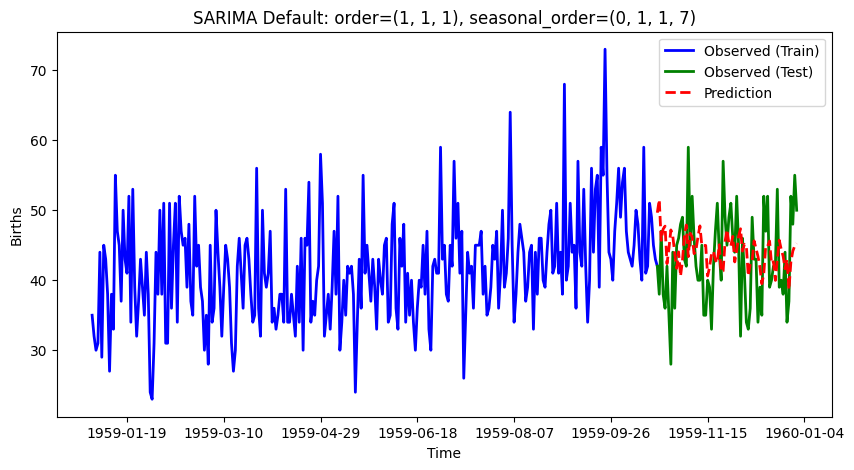

RMSE: 7.13


np.float64(7.134101381959051)

In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (1, 1, 1)
seasonal_order = (0, 1, 1, 7)

history = list(train['Births'])
preds = []
for t in range(len(test)):
    model = SARIMAX(
        history,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    pred = model.forecast(1)[0]
    preds.append(pred)
    history.append(test['Births'].iloc[t])

plot_walk_forward(
    train, test, preds, col='Births',
    title=f"SARIMA Default: order={order}, seasonal_order={seasonal_order}",
    ylabel="Births"
)

In [98]:
import itertools
import warnings
warnings.filterwarnings("ignore")

p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = [7]

param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

best_rmse = float('inf')
best_params = None
best_preds = None

for idx, (p_, d_, q_, P_, D_, Q_, s_) in enumerate(param_combinations):
    history = list(train['Births'])
    preds = []
    try:
        for t in range(len(test)):
            model = SARIMAX(
                history,
                order=(p_, d_, q_),
                seasonal_order=(P_, D_, Q_, s_),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            pred = model.forecast(1)[0]
            preds.append(pred)
            history.append(test['Births'].iloc[t])
        rmse = np.sqrt(mean_squared_error(test['Births'], preds))
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = ((p_, d_, q_), (P_, D_, Q_, s_))
            best_preds = preds
        print('.', end='', flush=True)
    except Exception:
        print('x', end='', flush=True)

print(f"\nBest params: order={best_params[0]}, seasonal_order={best_params[1]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Births',
    title=f"SARIMA Best: order={best_params[0]}, seasonal_order={best_params[1]}",
    ylabel="Births"
)

.......................................................

KeyboardInterrupt: 

### Prophet

In [ ]:
from prophet import Prophet

# Ensure index is datetime
if not pd.api.types.is_datetime64_any_dtype(train.index):
    train = train.copy()
    test = test.copy()
    train['Date'] = pd.date_range(start='1959-01-01', periods=len(train), freq='D')
    test['Date'] = pd.date_range(start=train['Date'].iloc[-1] + pd.offsets.Day(1), periods=len(test), freq='D')
    train.set_index('Date', inplace=True)
    test.set_index('Date', inplace=True)

train_prophet = train.reset_index().rename(columns={train.index.name or 'index': 'ds', 'Births': 'y'})
test_prophet = test.reset_index().rename(columns={test.index.name or 'index': 'ds', 'Births': 'y'})
train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])

history = train_prophet.copy()
preds = []
for t in range(len(test)):
    m = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
    m.fit(history)
    future = pd.DataFrame({'ds': [test_prophet['ds'].iloc[t]]})
    forecast = m.predict(future)
    pred = forecast['yhat'].values[0]
    preds.append(pred)
    history = pd.concat([history, test_prophet.iloc[[t]]], ignore_index=True)

plot_walk_forward(
    train, test, preds, col='Births',
    title="Walk Forward Validation: Prophet (default)",
    ylabel="Births"
)

In [ ]:
seasonality_modes = ['additive', 'multiplicative']
changepoint_scales = [0.01, 0.1, 0.5]

best_rmse = float('inf')
best_params = None
best_preds = None

for mode in seasonality_modes:
    for cps in changepoint_scales:
        history = train_prophet.copy()
        preds = []
        try:
            for t in range(len(test)):
                m = Prophet(
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=False,
                    seasonality_mode=mode,
                    changepoint_prior_scale=cps
                )
                m.fit(history)
                future = pd.DataFrame({'ds': [test_prophet['ds'].iloc[t]]})
                forecast = m.predict(future)
                pred = forecast['yhat'].values[0]
                preds.append(pred)
                history = pd.concat([history, test_prophet.iloc[[t]]], ignore_index=True)
            rmse = np.sqrt(mean_squared_error(test['Births'], preds))
            print(f"mode={mode}, changepoint_prior_scale={cps}, RMSE={rmse:.2f}")
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (mode, cps)
                best_preds = preds
        except Exception as e:
            print(f"FAILED: mode={mode}, changepoint_prior_scale={cps} ({e})")

print(f"\nBest params: mode={best_params[0]}, changepoint_prior_scale={best_params[1]}, RMSE={best_rmse:.2f}")

plot_walk_forward(
    train, test, best_preds, col='Births',
    title=f"Prophet Best: mode={best_params[0]}, changepoint_prior_scale={best_params[1]}",
    ylabel="Births"
)

### Comparacion y Evaluacion

## Rendimiento y Comparacion de Algoritmos

## Conclusiones